In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

(464, 460, 4)


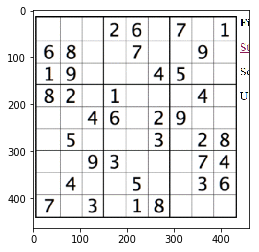

In [13]:
imagename = "SimpleBoard_1.png"
img = cv.imread(imagename, cv.IMREAD_UNCHANGED)
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
def main(filename: str) -> None:
    img_gray = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    img_color = cv.imread(filename, cv.IMREAD_UNCHANGED)
    plot_image(img_gray, 'gray')
    if img_gray is not None and img_color is not None:
        logger.info(f"Image {filename} successfuly read!")
        cropped_image = find_lines(img_gray, img_color, 10)
        # plot_image(cropped_image, 'gray')
        # boxes = resize_images_to_mnist(get_single_boxes(cropped_image))
        # for row in range(9):
        #     row_numbers = []
        #     for col in range(9):
        #         # plot_image(boxes[row+col], 'gray')
        #         if doesBoxContainDigit(boxes[row+col]):
        #             cv.imwrite(f"input_images/SingleBox_{row}-{col}.png",
        #                        boxes[row+col])
        #             reformated_box = boxes[row+col].reshape(1, 28, 28).astype(
        #                 'float32') / 255.0
        #             prediction = recognizer.predict(reformated_box)
        #         else:
        #             prediction = 0
        #         row_numbers.append(prediction)
        #     board.add_row(row_numbers)
        # board.pretty_print()
    else:
        logger.error(f"Couldn't open image {filename} !")


def doesBoxContainDigit(image) -> bool:
    threshold: float = 230.0
    mean = cv.mean(image)
    # print(f"Mean of image: {mean}")
    return mean[0] < threshold


def threshold_image(image):
    max_val: int = 255
    return cv.adaptiveThreshold(image, max_val, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv.THRESH_BINARY, 11, 2)


def find_lines(image_grayscale, image_color, min_line_length: int):
    def restructure_array(lines) -> List:
        return [line[0].tolist() for line in lines]

    def find_boundaries(lines: List) -> List:
        logger.debug("Found boundaries:\n%s", lines)
        result = []
        lines.sort(key=lambda points: points[0])
        result.append(lines[0])
        result.append(lines[-1])
        lines.sort(key=lambda points: points[3])
        result.append(lines[0])
        result.append(lines[-1])
        return result

    def draw_boundary(boundaries: List, image_color) -> None:
        color = (0, 255, 0)
        width = 2
        for boundary in boundaries:
            x1, y1, x2, y2 = boundary
            logger.debug(f"Drawn boundaries: ({x1}, {y1}) -> ({x2}, {y2})")
            cv.line(image_color, (x1, y1), (x2, y2), color, width)
        return image_color

    def crop_image(boundaries: List):
        x1 = boundaries[0][0]
        x2 = boundaries[1][0]
        y1 = boundaries[2][1]
        y2 = boundaries[3][1]
        logger.debug(f"Crop image to [{x1}:{x2}, {y1}:{y2}]")
        return image_grayscale[y1:y2, x1:x2]

    lowThreshold: int = 200
    highThreshold: int = 220
    rho: int = 1
    theta: int = np.pi/180
    threshold: int = 200
    minLineLength: int = min_line_length
    maxLineGap: int = 8
    edges = cv.Canny(image_grayscale, lowThreshold, highThreshold,
                     apertureSize=3)
    plot_image(edges, 'gray')
    lines = cv.HoughLinesP(edges, rho, theta, threshold, minLineLength,
                           maxLineGap)
    if lines is None:
        logger.error("Didn't found any lines!")
        return

    draw_boundary(find_boundaries(restructure_array(
        lines)), image_color)
    plot_image(cv.cvtColor(image_color, cv.COLOR_BGR2RGB), None)
    return crop_image(find_boundaries(restructure_array(lines)))


def get_single_boxes(image) -> List:
    """
    Slices image to 81 boxes in which should be one box from sudoku board

    Arguments:
        image {np.array} -- openCV's image

    Returns:
        List -- list of 81 single box images.
    """
    width, height = image.shape
    box_width = width // 9
    box_height = height // 9

    single_boxes = []
    for x in range(9):
        for y in range(9):
            start_x: int = x * box_width
            start_y: int = y * box_height
            single_boxes.append(image[start_x:(start_x + box_width),
                                      start_y:(start_y + box_height)])
    return single_boxes


def resize_images_to_mnist(image_list: List) -> List:
    """
    Resizes each image in list to 28x28px.

    Arguments:
        image_list {List} -- list of openCV's images

    Returns:
        List -- list of openCV's images in different size.
    """
    mnist_dim: Tuple[int, int] = (28, 28)
    result = []
    for image in image_list:
        result.append(cv.resize(image, mnist_dim, interpolation=cv.INTER_AREA))
    return result